## Carregando os dados

In [1]:
import pandas as pd

df = pd.read_csv('initial_dataset.csv', sep=';', encoding='utf-8').sample(30000)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 54509 to 28232
Columns: 3755 entries, x1 to target
dtypes: bool(1), float64(8), int64(3746)
memory usage: 859.5 MB


### Desbalanceamento

Dataset extremamente desbalanceado, com **99,4%** dos dados pertencendo a uma classe.

In [2]:
df.target.value_counts() / df.shape[0]

False    0.993133
True     0.006867
Name: target, dtype: float64

In [3]:
(df.isna().sum() / df.shape[0]).sort_values(ascending=False)[:10]

x3       0.622700
x4       0.038400
x5       0.030667
x7       0.002100
x8       0.001933
x1       0.001833
x2       0.001800
x6       0.000167
x1256    0.000000
x1251    0.000000
dtype: float64

## Abordagem Class Weight

### Distribuição em 2D

Counter({False: 29794, True: 206})


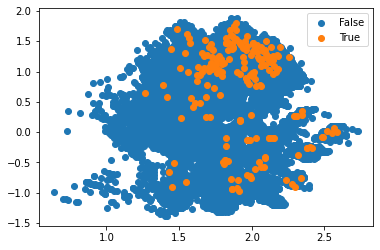

In [4]:
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

y = df.target
X = df.drop('target', axis=1).fillna(-1)
del df

X2 = TruncatedSVD(n_components=2).fit_transform(X)

counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X2[row_ix, 0], X2[row_ix, 1], label=str(label))
plt.legend()
plt.show()

### Treinamento

ROC_AUC  0.8078753997069417
Recall  0.7580645161290323
Precision  0.0356330553449583
F1  0.06806661839246922


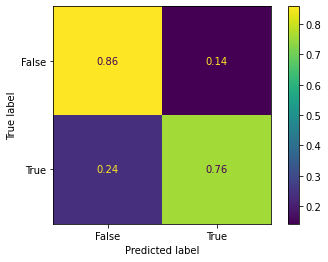

In [5]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=42, stratify=y)

cls = RandomForestClassifier(class_weight='balanced', max_depth=6)
cls.fit(X_train, y_train)

y_pred = cls.predict(X_test)
print('ROC_AUC ', metrics.roc_auc_score(y_test, y_pred))
print('Recall ', metrics.recall_score(y_test, y_pred))
print('Precision ', metrics.precision_score(y_test, y_pred))
print('F1 ', metrics.f1_score(y_test, y_pred))
metrics.plot_confusion_matrix(cls, X_test, y_test, normalize='true');

## Abordagem Random Over Sample

### Ajustando balanceamento

In [6]:
from imblearn import over_sampling as over

oversample = over.RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)

y_over.value_counts()

True     29794
False    29794
Name: target, dtype: int64

In [7]:
X_over.shape[0] == y_over.shape[0]

True

### Distribuição em 2D

*Não há alteração perceptível porque os data points se sobrepõem*

Counter({False: 29794, True: 29794})


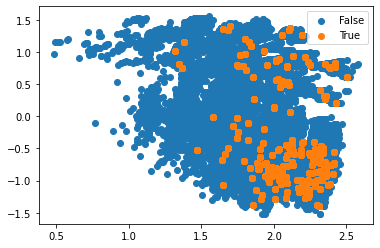

In [8]:
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

X2 = TruncatedSVD(n_components=2).fit_transform(X_over)

counter = Counter(y_over)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y_over == label)[0]
    plt.scatter(X2[row_ix, 0], X2[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, train_size=.7, random_state=42, stratify=y_over)

In [10]:
from sklearn.ensemble import RandomForestClassifier

cls = RandomForestClassifier(max_depth=25)
cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=25)

ROC_AUC  0.9686206510795391
Recall  1.0
Precision  0.940941151700179
F1  0.9695720561913543


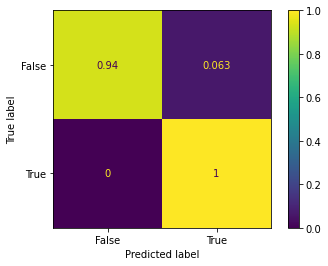

In [11]:
from sklearn import metrics

y_pred = cls.predict(X_test)
print('ROC_AUC ', metrics.roc_auc_score(y_test, y_pred))
print('Recall ', metrics.recall_score(y_test, y_pred))
print('Precision ', metrics.precision_score(y_test, y_pred))
print('F1 ', metrics.f1_score(y_test, y_pred))


metrics.plot_confusion_matrix(cls, X_test, y_test, normalize='true');

## Abordagem Over and Under Random Sample

In [12]:
from imblearn import over_sampling as over
from imblearn import under_sampling as under


over = over.RandomOverSampler(sampling_strategy=0.1)
X_over, y_over = over.fit_resample(X, y)
print(y_over.value_counts())
under = under.RandomUnderSampler(sampling_strategy=0.5)
X_ou, y_ou = under.fit_resample(X_over, y_over)
print(y_ou.value_counts())


False    29794
True      2979
Name: target, dtype: int64
False    5958
True     2979
Name: target, dtype: int64


### Distribuição 2D

*Redução dos data points azuis e data points laranja ainda se sobrepondo*

Counter({False: 5958, True: 2979})


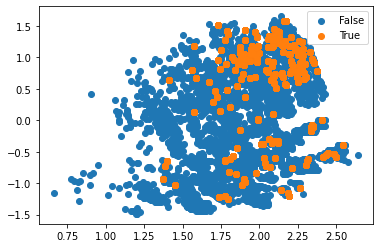

In [13]:
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

X2 = TruncatedSVD(n_components=2).fit_transform(X_ou)

counter = Counter(y_ou)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y_ou == label)[0]
    plt.scatter(X2[row_ix, 0], X2[row_ix, 1], label=str(label))
plt.legend()
plt.show()

### Treinamento

ROC_AUC  0.9798657718120807
Recall  0.9787472035794184
Precision  0.9625962596259626
F1  0.9706045479755963


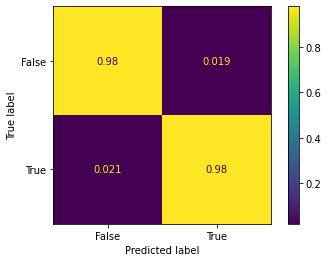

In [14]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(X_ou, y_ou, train_size=.7, random_state=42, stratify=y_ou)

cls = RandomForestClassifier(max_depth=25)
cls.fit(X_train, y_train)

y_pred = cls.predict(X_test)
print('ROC_AUC ', metrics.roc_auc_score(y_test, y_pred))
print('Recall ', metrics.recall_score(y_test, y_pred))
print('Precision ', metrics.precision_score(y_test, y_pred))
print('F1 ', metrics.f1_score(y_test, y_pred))
metrics.plot_confusion_matrix(cls, X_test, y_test, normalize='true');

## Abordagem SMOTE

In [15]:
from imblearn import over_sampling as over

smote = over.SMOTE()
X_over, y_over = smote.fit_resample(X, y)

y_over.value_counts()

True     29794
False    29794
Name: target, dtype: int64

### Distrinuição em 2D

*Claro preenchimento do campo 2D por novos data points laranja*

Counter({False: 29794, True: 29794})


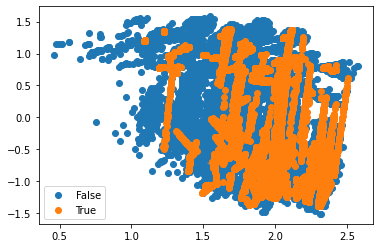

In [16]:
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

X2 = TruncatedSVD(n_components=2).fit_transform(X_over)

counter = Counter(y_over)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y_over == label)[0]
    plt.scatter(X2[row_ix, 0], X2[row_ix, 1], label=str(label))
plt.legend()
plt.show()

ROC_AUC  0.9642572275313919
Recall  0.990713806220631
Precision  0.940920199766231
F1  0.9651752139081148


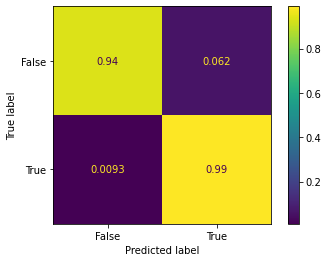

In [17]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, train_size=.7, random_state=42, stratify=y_over)

cls = RandomForestClassifier(max_depth=25)
cls.fit(X_train, y_train)

y_pred = cls.predict(X_test)
print('ROC_AUC ', metrics.roc_auc_score(y_test, y_pred))
print('Recall ', metrics.recall_score(y_test, y_pred))
print('Precision ', metrics.precision_score(y_test, y_pred))
print('F1 ', metrics.f1_score(y_test, y_pred))
metrics.plot_confusion_matrix(cls, X_test, y_test, normalize='true');

## Abordagem SMOTE com variação de centroides

In [18]:
from sklearn import metrics
from imblearn import over_sampling as over
from sklearn.ensemble import RandomForestClassifier

for k in range(1, 9):
    smote = over.SMOTE(k_neighbors=k)
    X_over, y_over = smote.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, train_size=.7, random_state=42, stratify=y_over)
    cls = RandomForestClassifier(max_depth=25)
    cls.fit(X_train, y_train)

    y_pred = cls.predict(X_test)
    print('-----'*5)
    print('K = %s' % k)
    print('ROC_AUC ', metrics.roc_auc_score(y_test, y_pred))
    print('Recall ', metrics.recall_score(y_test, y_pred))
    print('Precision ', metrics.precision_score(y_test, y_pred))
    print('F1 ', metrics.f1_score(y_test, y_pred))

-------------------------
K = 1
ROC_AUC  0.9673898005053571
Recall  0.9948534347728798
Precision  0.9430480432707604
F1  0.9682582893232428
-------------------------
K = 2
ROC_AUC  0.969291673098924
Recall  0.996531662564332
Precision  0.9450397877984085
F1  0.9701029243587648
-------------------------
K = 3
ROC_AUC  0.9673897441826882
Recall  0.9938464980980085
Precision  0.9438954415046222
F1  0.9682271513433974
-------------------------
K = 4
ROC_AUC  0.9647605832234896
Recall  0.9897068695457597
Precision  0.9426683716965046
F1  0.965615107521013
-------------------------
K = 5
ROC_AUC  0.9664387108857527
Recall  0.9912732154844485
Precision  0.9443615433809422
F1  0.9672489082969432
-------------------------
K = 6
ROC_AUC  0.9630265709575135
Recall  0.9890355784291788
Precision  0.9401254918642986
F1  0.9639605255983861
-------------------------
K = 7
ROC_AUC  0.9619078212686962
Recall  0.9880286417543075
Precision  0.9389686337054758
F1  0.9628741209180613
-----------------------

### Melhores resultados encontrados com 2 centroides

Counter({False: 29794, True: 29794})


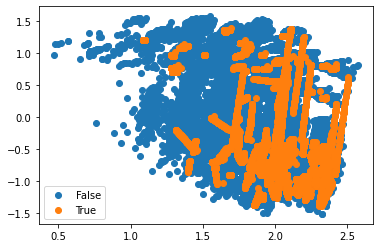

In [20]:
from sklearn.decomposition import TruncatedSVD
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

smote = over.SMOTE(k_neighbors=2)
X_over, y_over = smote.fit_resample(X, y)
X2 = TruncatedSVD(n_components=2).fit_transform(X_over)

counter = Counter(y_over)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y_over == label)[0]
    plt.scatter(X2[row_ix, 0], X2[row_ix, 1], label=str(label))
plt.legend()
plt.show()

ROC_AUC  0.9650403191457698
Recall  0.9908256880733946
Precision  0.942227896584743
F1  0.9659159077275454


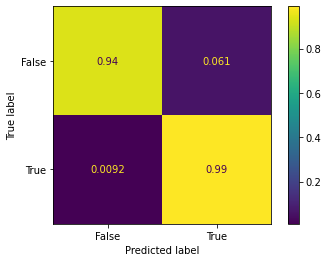

In [21]:
y_pred = cls.predict(X_test)
print('ROC_AUC ', metrics.roc_auc_score(y_test, y_pred))
print('Recall ', metrics.recall_score(y_test, y_pred))
print('Precision ', metrics.precision_score(y_test, y_pred))
print('F1 ', metrics.f1_score(y_test, y_pred))
metrics.plot_confusion_matrix(cls, X_test, y_test, normalize='true');